In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/root/data/"


In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


# nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('wordnet')

def load_glove_vectors(glove_file_path):
    word_vectors = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_vectors[word] = vector
    return word_vectors

def preprocess_text(text):
    text = text.lower()                              # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)          # Remove special characters and numbers
    tokens = word_tokenize(text)                     # Tokenization
    stop_words = set(stopwords.words('english'))     # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # lemmatizer = WordNetLemmatizer()                 # Lemmatization  ex: running => run (not nesscessary, but i want to test)
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

glove_path = "/root/data/glove/"
word_vectors = load_glove_vectors(glove_path + "glove.6B.100d.txt")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def tokens_to_vectors(tokens):
    vectors = []
    for token in tokens:
        if token in word_vectors:
            vectors.append(word_vectors[token])
    if not vectors: # return none if no valid word vectors found 
        return None
    return np.mean(vectors, axis=0)


df_2nd = pd.read_csv(data_path +"2nd/" +"train.csv")
df_2nd = df_2nd.drop(['title','author','id'],axis=1)

df_2nd['text'] = df_2nd['text'].astype(str)
df_2nd['clean_text'] = df_2nd['text'].apply(preprocess_text)
df_2nd['doc_vector'] = df_2nd['clean_text'].apply(tokens_to_vectors)
df_2nd = df_2nd.dropna()


X_train, X_test, y_train, y_test = train_test_split(df_2nd['doc_vector'].to_list() , df_2nd['label'], test_size=0.2, random_state=42)

X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6255 - loss: 0.6608 - val_accuracy: 0.7532 - val_loss: 0.5384
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7401 - loss: 0.5323 - val_accuracy: 0.7774 - val_loss: 0.4926
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7537 - loss: 0.5112 - val_accuracy: 0.7852 - val_loss: 0.4739
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7588 - loss: 0.5046 - val_accuracy: 0.7901 - val_loss: 0.4631
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7647 - loss: 0.4947 - val_accuracy: 0.7937 - val_loss: 0.4604
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7614 - loss: 0.5021 - val_accuracy: 0.7913 - val_loss: 0.4552
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7651 - loss: 0.4892 - val_accuracy: 0.8070 - val_loss: 0.4515
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.4879 - val_accurac

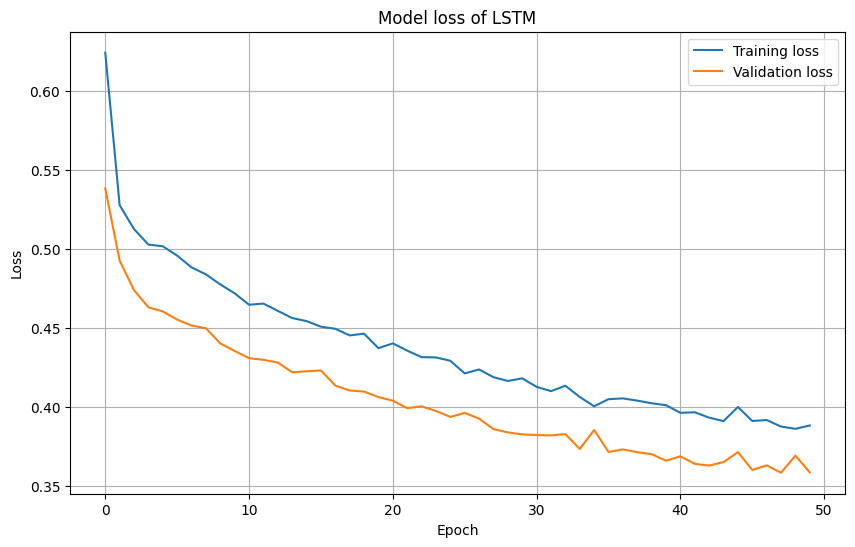

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D

max_len = len(X_train[0])

X_train_reshaped = np.reshape(X_train, (len(X_train), 1, max_len))
X_test_reshaped = np.reshape(X_test, (len(X_test), 1, max_len))

# Define the LSTM model
model0 = Sequential()
model0.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model0.add(Dense(1, activation='sigmoid'))

model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model0.summary())


# Train the model
history = model0.fit(X_train_reshaped, y_train, epochs=50, batch_size=128, validation_split=0.1)
loss, accuracy = model0.evaluate(X_test_reshaped, y_test)
y_pred = model0.predict(X_test_reshaped)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_probs = model0.predict(X_test_reshaped)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss of LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [14]:
import  numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_binary = np.round(y_pred).flatten()
print('----------------')
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred_binary))
print('----------------')
print('Classification report')
print(classification_report(y_test, y_pred_binary))

----------------
Confusion matrix
[[1809  286]
 [ 302 1734]]
----------------
Classification report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2095
           1       0.86      0.85      0.86      2036

    accuracy                           0.86      4131
   macro avg       0.86      0.86      0.86      4131
weighted avg       0.86      0.86      0.86      4131

